# 미션 9 개요

모델을 활용하여 FashionMNIST 데이터셋의 각 패션 아이템(예: 티셔츠, 바지, 스니커즈 등)을 조건부로 생성하는 작업을 수행한다.

각 클래스에 해당하는 이미지를 생성하는 cGAN (Conditional GAN) 모델을 직접 설계하고 학습

데이터
- torchvision.datasets.FashionMNIST로 다운로드
- 데이터 구성
    - 휸련 데이터 : 60,000장의 이미지
    - 테스트 데이터 : 10,000장의 이미지
    - 28 x 28 크기의 흑백 이미지 (10개 클래스)

- 클래스 목록:
    - T-shirt/top
    - Trouser
    - Pullover
    - Dress
    - Coat
    - Sandal
    - Shirt
    - Sneaker
    - Bag
    - Ankle boot

모델 성능 평가
- 조건부 레이블을 활용해 각 패션 아이템 클래스별로 이미지를 생성하는 모델을 구현
- 생성된 이미지의 품질을 정성적(시각적 평가) 및 정량적(FID, IS 등, optional)으로 평가

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
print("PyTorch:", torch.__version__)
print("MPS available:", torch.backends.mps.is_available())
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

os.makedirs("pth", exist_ok=True)

PyTorch: 2.7.1
MPS available: True
mps


# 데이터 불러오기

In [3]:
# 데이터셋 및 DataLoader 설정
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [-1, 1] 범위로 정규화
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# 클래스 이름 (FashionMNIST 클래스)
idx_to_class = {i: class_name for i, class_name in enumerate(train_dataset.classes)}
idx_to_class

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [ ]:
image_size = 28      # MNIST 이미지 크기
num_classes = 10     # 10개 클래스 (0~9)
latent_dim = 100     # 잠재 공간 차원

# 생성자 (Generator)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # 레이블 임베딩
        self.label_emb = nn.Embedding(num_classes, num_classes) #--> 10 * 10 like one-hot

        self.init_size = image_size // 4  # 7

        self.l1 = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128 * self.init_size * self.init_size),
            nn.ReLU(inplace=True)
        )

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),  # 7 → 14
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, momentum=0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),  # 14 → 28
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # 출력 범위 [-1, 1]
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        gen_input = torch.cat((noise, label_input), -1)
        out = self.l1(gen_input)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# 판별자 (Discriminator)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # 레이블을 단일 채널 값으로 임베딩
        self.label_emb = nn.Embedding(num_classes, 1)

        self.model = nn.Sequential(
            # 이미지(1 채널)와 레이블(1 채널)을 채널 차원에서 결합하여 2채널로 입력
            nn.Conv2d(1 + 1, 64, kernel_size=3, stride=2, padding=1),  # 28 → 14
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),      # 14 → 7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128 * (image_size // 4) * (image_size // 4), 1),   # 128*7*7
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        batch_size = img.size(0)
        label = self.label_emb(labels)
        label = label.view(batch_size, 1, 1, 1)
        label = label.expand(batch_size, 1, image_size, image_size)
        # 이미지와 레이블을 채널 차원에서 연결
        d_in = torch.cat((img, label), 1)
        validity = self.model(d_in)
        return validity

Epoch [1/30]  D_loss: 0.9173  G_loss: 1.2292  D(x): 0.66  D(G(z)): 0.34
Epoch [2/30]  D_loss: 0.9391  G_loss: 1.2761  D(x): 0.66  D(G(z)): 0.34
Epoch [3/30]  D_loss: 1.0888  G_loss: 1.0895  D(x): 0.61  D(G(z)): 0.39
Epoch [4/30]  D_loss: 1.0970  G_loss: 1.0904  D(x): 0.61  D(G(z)): 0.39
Epoch [5/30]  D_loss: 1.0736  G_loss: 1.1235  D(x): 0.61  D(G(z)): 0.39
Epoch [6/30]  D_loss: 1.0503  G_loss: 1.1640  D(x): 0.62  D(G(z)): 0.38
Epoch [7/30]  D_loss: 1.0483  G_loss: 1.1880  D(x): 0.62  D(G(z)): 0.37
Epoch [8/30]  D_loss: 1.0463  G_loss: 1.1951  D(x): 0.63  D(G(z)): 0.37
Epoch [9/30]  D_loss: 1.0480  G_loss: 1.2107  D(x): 0.63  D(G(z)): 0.37
Epoch [10/30]  D_loss: 1.0488  G_loss: 1.2172  D(x): 0.63  D(G(z)): 0.37


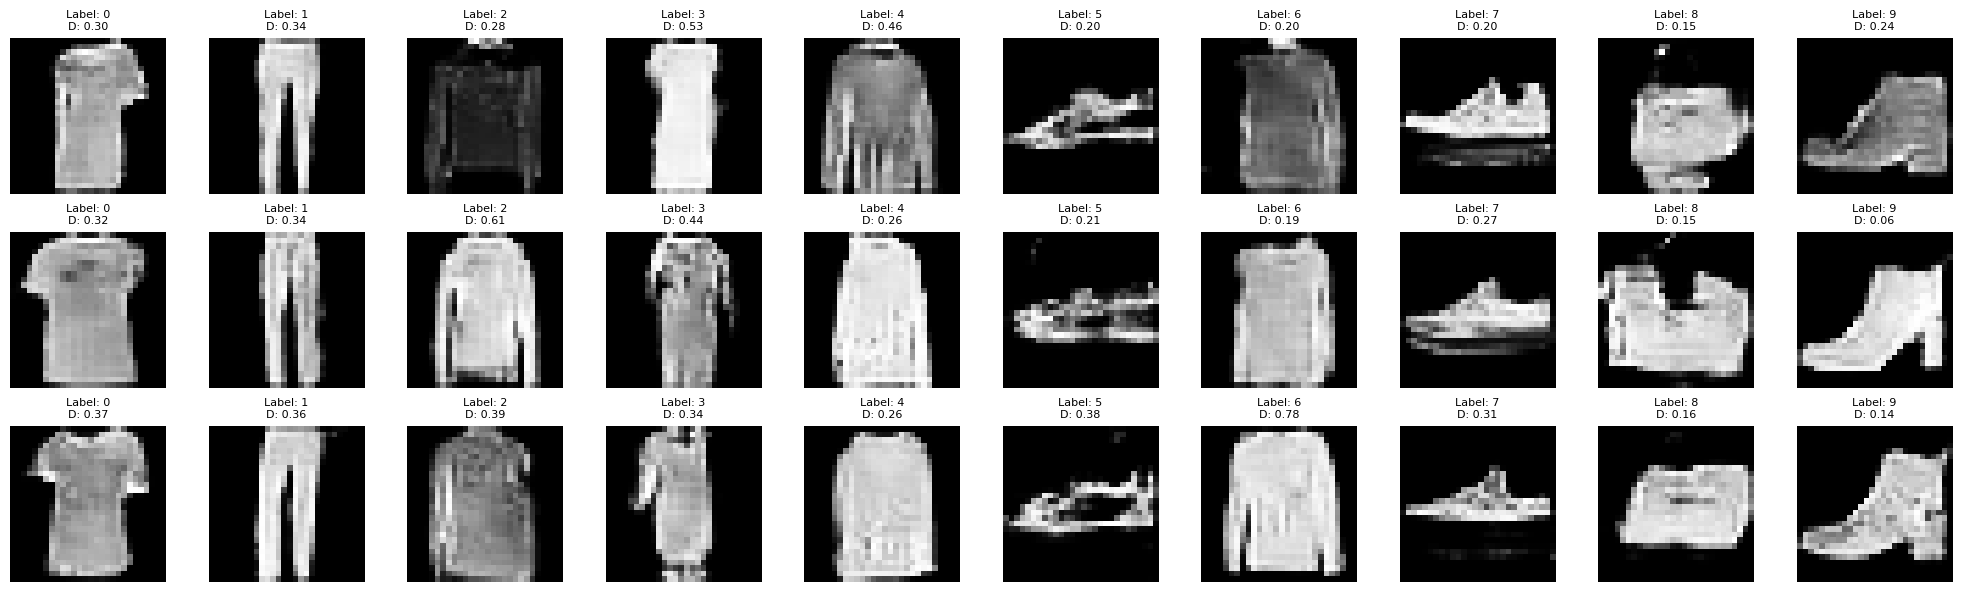

Epoch [11/30]  D_loss: 1.0364  G_loss: 1.2374  D(x): 0.63  D(G(z)): 0.37
Epoch [12/30]  D_loss: 1.0258  G_loss: 1.2613  D(x): 0.64  D(G(z)): 0.36
Epoch [13/30]  D_loss: 1.0304  G_loss: 1.2614  D(x): 0.64  D(G(z)): 0.36
Epoch [14/30]  D_loss: 1.0206  G_loss: 1.2781  D(x): 0.64  D(G(z)): 0.36
Epoch [15/30]  D_loss: 1.0136  G_loss: 1.2966  D(x): 0.64  D(G(z)): 0.36
Epoch [16/30]  D_loss: 1.0089  G_loss: 1.3074  D(x): 0.64  D(G(z)): 0.35
Epoch [17/30]  D_loss: 1.0109  G_loss: 1.3228  D(x): 0.65  D(G(z)): 0.35
Epoch [18/30]  D_loss: 1.0080  G_loss: 1.3260  D(x): 0.65  D(G(z)): 0.35
Epoch [19/30]  D_loss: 0.9924  G_loss: 1.3475  D(x): 0.65  D(G(z)): 0.35
Epoch [20/30]  D_loss: 0.9942  G_loss: 1.3471  D(x): 0.65  D(G(z)): 0.35


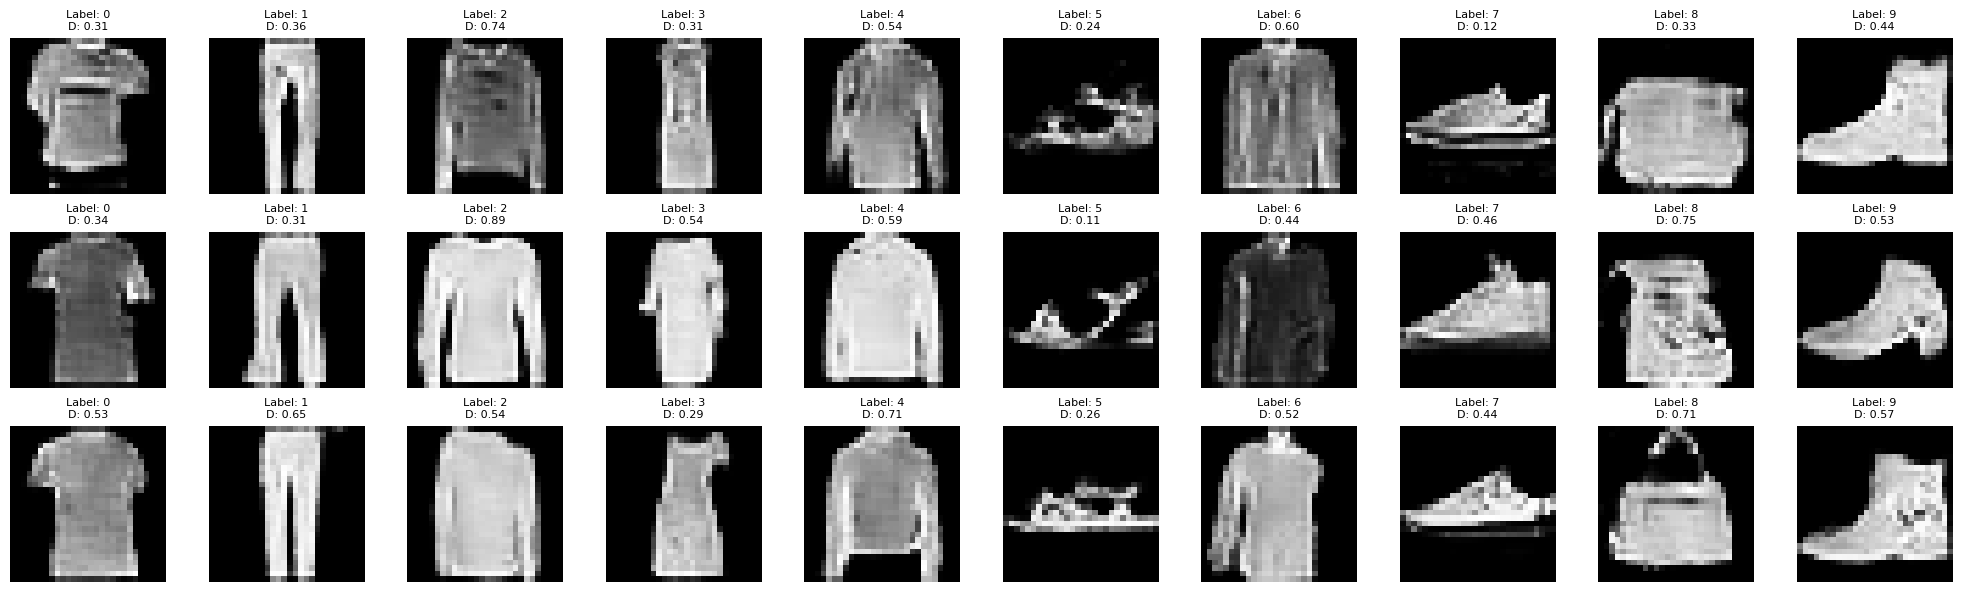

Epoch [21/30]  D_loss: 0.9875  G_loss: 1.3609  D(x): 0.65  D(G(z)): 0.35
Epoch [22/30]  D_loss: 0.9793  G_loss: 1.3782  D(x): 0.66  D(G(z)): 0.34
Epoch [23/30]  D_loss: 0.9717  G_loss: 1.3937  D(x): 0.66  D(G(z)): 0.34
Epoch [24/30]  D_loss: 0.9641  G_loss: 1.4162  D(x): 0.66  D(G(z)): 0.34
Epoch [25/30]  D_loss: 0.9685  G_loss: 1.4157  D(x): 0.66  D(G(z)): 0.34
Epoch [26/30]  D_loss: 0.9590  G_loss: 1.4301  D(x): 0.66  D(G(z)): 0.34
Epoch [27/30]  D_loss: 0.9559  G_loss: 1.4443  D(x): 0.67  D(G(z)): 0.33
Epoch [28/30]  D_loss: 0.9471  G_loss: 1.4559  D(x): 0.67  D(G(z)): 0.33
Epoch [29/30]  D_loss: 0.9433  G_loss: 1.4687  D(x): 0.67  D(G(z)): 0.33
Epoch [30/30]  D_loss: 0.9382  G_loss: 1.4838  D(x): 0.67  D(G(z)): 0.33


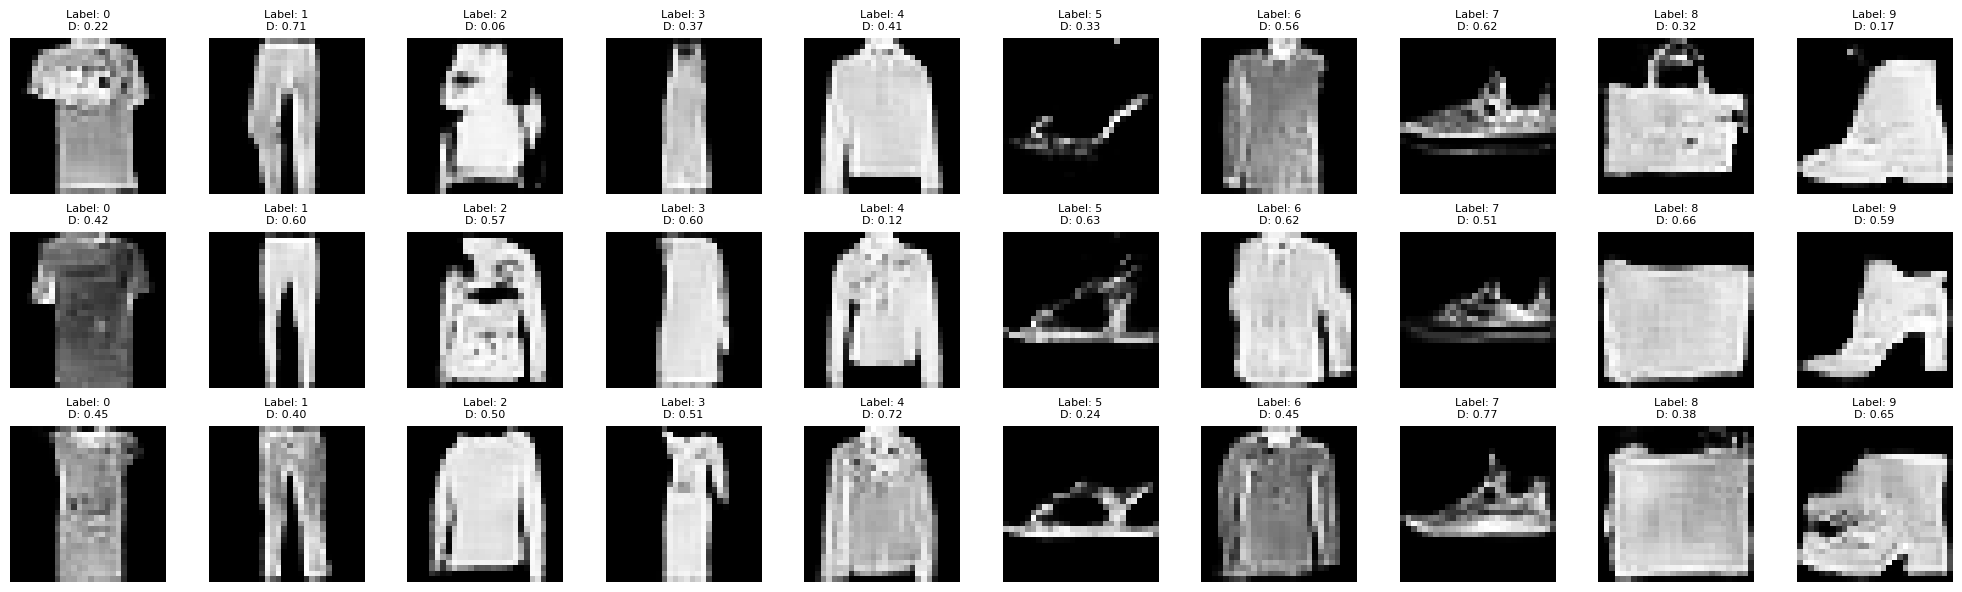

In [5]:
# 모델 초기화
generator = Generator().to(device)
discriminator = Discriminator().to(device)

epochs = 30
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# 학습 루프 (에포크마다 D(x)와 D(G(z)) 평균 점수 계산)
for epoch in range(epochs):
    running_d_loss = 0.0
    running_g_loss = 0.0
    d_x_total = 0.0
    d_gz_total = 0.0
    total_samples = 0

    for i, (imgs, labels) in enumerate(train_loader):
        batch_size_current = imgs.size(0)
        total_samples += batch_size_current
        imgs = imgs.to(device)
        labels = labels.to(device)

        valid = torch.ones(batch_size_current, 1, device=device)
        fake  = torch.zeros(batch_size_current, 1, device=device)

        # 판별자 학습
        optimizer_D.zero_grad()
        # 실제 이미지에 대한 판별자 출력
        real_pred = discriminator(imgs, labels)
        real_loss = criterion(real_pred, valid)
        d_x_total += real_pred.mean().item() * batch_size_current

        noise = torch.randn(batch_size_current, latent_dim, device=device)
        gen_labels = labels  # (여기서는 입력된 라벨 사용)
        gen_imgs = generator(noise, gen_labels)
        # 가짜 이미지에 대한 판별자 출력
        fake_pred = discriminator(gen_imgs.detach(), labels)
        fake_loss = criterion(fake_pred, fake)
        d_gz_total += fake_pred.mean().item() * batch_size_current

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # 생성자 학습
        optimizer_G.zero_grad()
        g_loss = criterion(discriminator(gen_imgs, labels), valid)
        g_loss.backward()
        optimizer_G.step()

        running_d_loss += d_loss.item() * batch_size_current
        running_g_loss += g_loss.item() * batch_size_current

    avg_d_loss = running_d_loss / total_samples
    avg_g_loss = running_g_loss / total_samples
    avg_d_x = d_x_total / total_samples
    avg_d_gz = d_gz_total / total_samples

    print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {avg_d_loss:.4f}  G_loss: {avg_g_loss:.4f}  D(x): {avg_d_x:.2f}  D(G(z)): {avg_d_gz:.2f}")

    # 10 에포크마다 생성 이미지 시각화 (각 클래스별로 3개씩 출력)
    if (epoch + 1) % 10 == 0:
        generator.eval()
        n_row = 3               # 각 클래스당 3개씩
        n_col = num_classes     # 총 10개 클래스
        total_samples_vis = n_row * n_col
        noise = torch.randn(total_samples_vis, latent_dim, device=device)
        labels_sample = torch.arange(0, num_classes, device=device).repeat(n_row)
        with torch.no_grad():
            gen_imgs = generator(noise, labels_sample)
            disc_out = discriminator(gen_imgs, labels_sample)
        gen_imgs = gen_imgs.detach().cpu().numpy()
        disc_out = disc_out.detach().cpu().numpy()

        fig, axs = plt.subplots(n_row, n_col, figsize=(n_col * 2, n_row * 2))
        for i in range(n_row):
            for j in range(n_col):
                idx = i * n_col + j
                axs[i, j].imshow(gen_imgs[idx, 0, :, :], cmap='gray')
                axs[i, j].axis('off')
                score = disc_out[idx, 0]
                axs[i, j].set_title(f"Label: {labels_sample[idx].item()}\nD: {score:.2f}", fontsize=8)
        plt.tight_layout()
        plt.show()
        generator.train()

생성된 이미지의 shape: torch.Size([8, 1, 28, 28])
판별자 출력의 shape: torch.Size([8, 1])


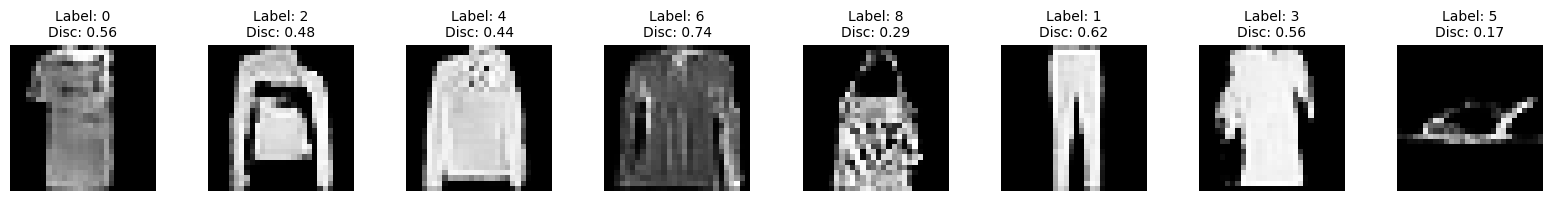

In [6]:
# generator와 discriminator 작동 확인 및 시각화 (라벨, 판별자 결과 포함)
generator.eval()
discriminator.eval()

# 사용자가 직접 입력한 라벨 (예: [0, 2, 4, 6, 8, 1, 3, 5])
manual_labels = torch.tensor([0, 2, 4, 6, 8, 1, 3, 5], device=device)
batch_size = manual_labels.size(0)

# 입력 라벨에 맞춰 노이즈 생성
noise = torch.randn(batch_size, latent_dim, device=device)

# 생성자와 판별자 실행
with torch.no_grad():
    fake_images = generator(noise, manual_labels)
    disc_output = discriminator(fake_images, manual_labels)

print("생성된 이미지의 shape:", fake_images.shape)  # 예상: [batch_size, 1, 28, 28]
print("판별자 출력의 shape:", disc_output.shape)     # 예상: [batch_size, 1]

# 결과 시각화: 생성된 이미지와 라벨, 판별자 결과를 함께 표시
import matplotlib.pyplot as plt

fake_images_cpu = fake_images.detach().cpu().numpy()
disc_output_cpu = disc_output.detach().cpu().numpy()

fig, axs = plt.subplots(1, batch_size, figsize=(batch_size * 2, 2))
for i in range(batch_size):
    axs[i].imshow(fake_images_cpu[i, 0, :, :], cmap='gray')
    axs[i].axis('off')
    score = disc_output_cpu[i, 0]
    axs[i].set_title(f"Label: {manual_labels[i].item()}\nDisc: {score:.2f}", fontsize=10)
plt.tight_layout()
plt.show()
